<a href="https://colab.research.google.com/github/DimitriosK/Online-Education/blob/main/Online_Platform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Background and Task

Online education services, such as Khan Academy and Coursera, provide a broader audience with
access to high-quality education. On these platforms, students can learn new materials by watching
a lecture, reading course material, and talking to instructors in a forum. However, one disadvantage
of the online platform is that it is challenging to measure students’ understanding of the course
material. To deal with this issue, many online education platforms include an assessment component
to ensure that students understand the core topics. The assessment component is often composed
of diagnostic questions, each a multiple choice question with one correct answer. The diagnostic
question is designed so that each of the incorrect answers highlights a common misconception.

In this project, we will build machine learning algorithms to predict whether a student can correctly
answer a specific diagnostic question based on the student’s previous answers to other questions
and other students’ responses. Predicting the correctness of students’ answers to as yet unseen
diagnostic questions helps estimate the student’s ability level in a personalized education platform.
Moreover, these predictions form the groundwork for many advanced customized tasks. For instance, using the predicted correctness, the online platform can automatically recommend a set of
diagnostic questions of appropriate difficulty that fit the student’s background and learning status.

Import useful libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.metrics import plot_confusion_matrix, roc_curve, roc_auc_score,auc
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import VotingClassifier
import missingno
import random
import math
import warnings 
warnings.filterwarnings("ignore")

#Gather Data



In [2]:
!wget http://www.cs.toronto.edu/~rgrosse/courses/csc311_f20/project/final_project.zip
!unzip final_project.zip

--2023-01-17 23:56:56--  http://www.cs.toronto.edu/~rgrosse/courses/csc311_f20/project/final_project.zip
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444833 (434K) [application/zip]
Saving to: ‘final_project.zip’

final_project.zip   100%[===================>] 434.41K  --.-KB/s    in 0.1s    

2023-01-17 23:56:57 (3.19 MB/s) - ‘final_project.zip’ saved [444833/444833]

Archive:  final_project.zip
   creating: starter_code/
  inflating: starter_code/majority_vote.py  
  inflating: starter_code/utils.py   
   creating: starter_code/part_a/
  inflating: starter_code/part_a/item_response.py  
  inflating: starter_code/part_a/__init__.py  
  inflating: starter_code/part_a/knn.py  
  inflating: starter_code/part_a/matrix_factorization.py  
  inflating: starter_code/part_a/ensemble.py  
  inflating: starter_code/part_a/neural_network.

In [3]:
!ls starter_code/

data  majority_vote.py	part_a	utils.py


In [4]:
import sys
sys.path.append('starter_code/')

The `utils ` file contains functions that can load 
 * training data (load_train_csv)
 * validation data (load_valid_data)
 * test data (load_public_test_csv)

In [5]:
from utils import * 

#Description of the problem
We have a binary classification problem:
 * The features are `student_id` and `question_id`
 * The target is `is_correcrt` $\in\{0,1\}$. The value 1 indicates that the student answered the corresponding question correctly and 0 indicates the student answered the  corresponding question wrong.

We are given train, validation and test set represented in a dictionary format.

In [6]:
train_data = load_train_csv("starter_code/data")
valid_data = load_valid_csv("starter_code/data")
test_data = load_public_test_csv("starter_code/data")

For the purpose of an easy manipualtion of the data, we express our train, validation, test data via dataframes.

In [7]:
df_train=pd.DataFrame(train_data)
df_valid=pd.DataFrame(valid_data)
df_test=pd.DataFrame(test_data)

In [8]:
df_train.head()

,user_id,question_id,is_correct
0,488,1525,1
1,355,1574,1
2,123,1030,1
3,116,1131,0
4,12,773,0


In [9]:
df_train.shape

(56688, 3)

The data is slightly imbalanced

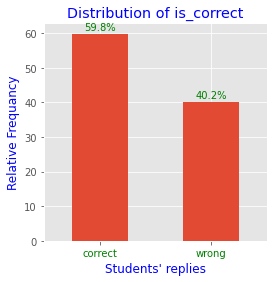

In [10]:
plt.style.use('ggplot')
plt.figure(figsize=(4,4))
rel_freq=df_train['is_correct'].value_counts(normalize=True,
                                             ascending=False)*100
rel_freq.plot(kind='bar',
              rot=0)
for i in range(rel_freq.shape[0]):
    plt.text(i,rel_freq.iloc[i]+0.5,str(round(rel_freq.iloc[i],1))+"%",
             ha="center",va="bottom",color="g")
plt.ylabel('Relative Frequancy',color='blue')
plt.xlabel('Students\' replies',color='blue')
plt.xticks([0,1],['correct','wrong'],color='green')
plt.title('Distribution of is_correct',color='blue')
plt.savefig('target_plot',dpi=300,
            bbox_inches ="tight",
            pad_inches = 0.5,)                                   


In [11]:
#None of the above dataframes have missing values
frames=[df_train,df_valid,df_test]
for i,frame in enumerate(frames):
  print(f'The dataframe {i+1}')
  print(frame.isna().sum())
  print('************')
  print()

The dataframe 1
user_id        0
question_id    0
is_correct     0
dtype: int64
************

The dataframe 2
user_id        0
question_id    0
is_correct     0
dtype: int64
************

The dataframe 3
user_id        0
question_id    0
is_correct     0
dtype: int64
************



# Prepare data for a model

In [12]:
#prepare data for fitting a model
X_train=df_train.drop(columns='is_correct')
y_train=df_train['is_correct']
X_valid=df_valid.drop(columns='is_correct')
y_valid=df_valid['is_correct']
X_test=df_test.drop(columns='is_correct')
y_test=df_test['is_correct']


Although `user_id` and `question_id` have numerical values, we treat them as categorical features.

In [13]:
#Implement one hot encoding
ohe=OneHotEncoder(drop=None,handle_unknown='ignore',sparse=False)
X_train_ohe=ohe.fit_transform(X_train)
X_valid_ohe=ohe.transform(X_valid)
X_test_ohe=ohe.transform(X_test)

In [14]:
pd.DataFrame(X_train_ohe).head(2) #visualize  the first two rows after one hot encoding

,0,1,2,3,4,5,6,7,8,9,...,2306,2307,2308,2309,2310,2311,2312,2313,2314,2315
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Base Models
 * Logistic Regression
 * Random Forest
 * XGBoost

**Logistic Regression**

* The hyperparameter C is a regularization parameter. Bigger C smaller the coefficients in front of features are. Smaller C bigger the coefficients.
* The penalty term can be 'l2' (deafualt value), 'l1' and 'elasticnet' (combination of the other  two). 
* The hyperparameter class_weight helps us deal with imbalanced data.

**Logistic Regression (penalty=l2)**
 * We check the impact of C on the performance of logistic regression (penalty='l2'). We want to have a visual understanding of this impact.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#train logistic regression for different values of C
seed=42
param_range=[0.01, 0.1, 1.0, 10.0, 50.0,100.0,200.0]
validation_scores=[]
training_scores=[]
for C in param_range:
  clf=LogisticRegression(C=C,
                         solver='sag',
                         class_weight='balanced',
                         penalty='l2',
                         random_state=seed)
  clf.fit(X_train_ohe,y_train)
  training_score=clf.score(X_train_ohe,y_train)
  validation_score=clf.score(X_valid_ohe,y_valid)
  training_scores.append(training_score)
  validation_scores.append(validation_score)

In [ ]:
#prints the validation and training scores
print('The training scores are:')
print(training_scores)
print()
print('The validation scores are:')
print(validation_scores)

The training scores are:
[0.7032352526107818, 0.7223751058425063, 0.7343529494778437, 0.7355172170476997, 0.7354290149590742, 0.7356230595540503, 0.7352878916172735]

The validation scores are:
[0.6891052780129834, 0.6999717753316399, 0.7070279424216765, 0.7058989556872707, 0.7058989556872707, 0.7061812023708721, 0.7060400790290714]


In [ ]:
def validation_curve(param_range,training_scores,validation_scores):
  train_std=np.std(training_scores)
  valid_std=np.std(validation_scores)
  plt.plot(param_range, training_scores,
           color='blue', marker='o',
           markersize=5, label='Training accuracy')
  plt.fill_between(param_range, training_scores + train_std,
                   training_scores - train_std, alpha=0.15,
                   color='blue')
  plt.plot(param_range, validation_scores,
           color='green', linestyle='--',
           marker='s', markersize=5,
           label='Validation accuracy')
  plt.fill_between(param_range,
                   validation_scores +valid_std,
                   validation_scores -valid_std,
                   alpha=0.15, color='green')
  plt.grid('on')
  plt.xscale('log')
  plt.legend(loc='lower right')
  plt.xlabel('Parameter C',color='blue',fontsize=13)
  plt.ylabel('Accuracy',color='blue',fontsize=13)
  plt.ylim([0.6, 0.8])
  plt.title('Logistic Regression Performance',color='blue',fontsize=13)
  plt.savefig('C_logistic',dpi=300,
            bbox_inches ="tight",
            pad_inches = 0.5,)
  plt.show()
  

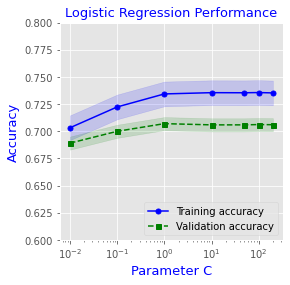

In [ ]:
param_range=[0.01, 0.1, 1.0, 10.0, 50.0,100.0,200.0]
training_scores=[0.7032352526107818, 0.7223751058425063, 0.7343529494778437, 0.7355172170476997, 0.7354290149590742, 
                 0.7356230595540503, 0.7352878916172735]
validation_scores=[0.6891052780129834, 0.6999717753316399, 0.7070279424216765, 
                   0.7058989556872707, 0.7058989556872707, 0.7061812023708721, 0.7060400790290714]
plt.figure(figsize=(4,4))
validation_curve(param_range,np.array(training_scores),np.array(validation_scores))


Based on this picture, we see that for smaller values of C, the model slightly underfits the data and start performing better for bigger values of C. The good spot to select C is is between 0.1 and 1.0.

In [ ]:
print(f'The average validation score is \
{np.mean(validation_scores)}+/-{np.std(validation_scores)}')

The average validation score is 0.7028748840772548+/-0.0060299040872848165


In [ ]:
#Highest validation score is achieved for C=10
print(f'The highest validation score is {max(validation_scores)}')
index=np.argsort(validation_scores)[-1]
print(f'The highest validation score is achived for C={param_range[index]}')

The highest validation score is 0.7070279424216765
The highest validation score is achived for C=1.0


Train Logistic Regression with C=1.0



In [ ]:
#train logistic regression for C=1.0 and penalty=l2
seed=42
lr_l2=LogisticRegression(C=1.0,
                         solver='sag',
                         class_weight='balanced',
                         random_state=seed)
lr_l2.fit(X_train_ohe,y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='sag')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seed=42
new_lr=LogisticRegression(C=0.5,
                         solver='sag',
                         class_weight='balanced',
                         random_state=seed)
new_lr.fit(X_train_ohe,y_train)

LogisticRegression(C=0.5, class_weight='balanced', random_state=42,
                   solver='sag')

In [ ]:
#save the model
#import joblib
#filename = '/content/drive/MyDrive/Colab Notebooks/Online Educational Platforms\
#/lr_l2_model_final_project.sav'
#joblib.dump(lr_l2, filename)

['/content/drive/MyDrive/Colab Notebooks/Online Educational Platforms/lr_l2_model_final_project.sav']

**Logistic Regression (penalty='elasticnet')**

We will tune the hyperparameters 'l1_ratio' (determines the weight we put on l1 and l2 penalty) and C (regularization hyperparameter).

In [ ]:
l1_ratio=[0.1,0.3,0.5,0.7]
c_params=[0.01, 0.1, 1.0, 10.0,50.0,100.0,200.0]
scores_train={}
scores_valid={}
for ratio in l1_ratio:
  for C in c_params:
    clf=LogisticRegression(penalty='elasticnet',
                      solver='saga',C=C,
                      class_weight='balanced',
                      l1_ratio=ratio)
    clf.fit(X_train_ohe,y_train)
    train_score=clf.score(X_train_ohe,y_train)
    valid_score=clf.score(X_valid_ohe,y_valid)
    scores_train[train_score]=(ratio,C)
    scores_valid[valid_score]=(ratio,C)

In [ ]:
print('The training scores are', list(scores_train.keys()))
print()
print('The validation scores',list(scores_valid.keys()))

The training scores are [0.6782917019475021, 0.7199054473609935, 0.7345999153259949, 0.7354819362122496, 0.7354995766299746, 0.7354290149590742, 0.7353584532881738, 0.6647615015523568, 0.7132020886254586, 0.7348468811741462, 0.735376093705899, 0.7353937341236241, 0.6481795088907706, 0.7030941292689811, 0.7343882303132938, 0.7354466553767993, 0.6350550381033023, 0.6940798758114592, 0.734441151566469]

The validation scores [0.68077900084674, 0.6970081851538245, 0.7068868190798758, 0.7060400790290714, 0.70575783234547, 0.7058989556872707, 0.6707592435788879, 0.6943268416596104, 0.7070279424216765, 0.6498729889923793, 0.6909398814563928, 0.7063223257126728, 0.6402766017499294, 0.683460344340954, 0.705193338978267, 0.7056167090036692]


In [ ]:
max_valid_score=max(list(scores_valid.keys()))
print('The highest validation score is',max_valid_score)
print()
print(f'The highest validation score is achieved for C={scores_valid[max_valid_score][1]} and \
the l1_ratio={scores_valid[max_valid_score][0]}')

The highest validation score is 0.7070279424216765

The highest validation score is achieved for C=1.0 and the l1_ratio=0.3


In [ ]:
print(f'The average validation score is {np.mean(list(scores_valid.keys())):.2f}+/-\
{np.std(list(scores_valid.keys())):.2f}')

The average validation score is 0.69+/-0.02


Since the average validation score for Logistic Regression with penalty='l2' is higher than for Logistic Regression with penalty='elasticnet' we will use the performance of Logistic Regression with penalty='l2' on our test set.

**Logistic Regreession (penalty='l1')**

In [ ]:
seed=42
param_range=[0.01, 0.1, 1.0, 10.0,100.0,1000]
validation_scores=[]
training_scores=[]
for C in param_range:
  clf=LogisticRegression(C=C,
                         solver='saga',
                         class_weight='balanced',
                         penalty='l1',
                         random_state=seed)
  clf.fit(X_train_ohe,y_train)
  training_score=clf.score(X_train_ohe,y_train)
  validation_score=clf.score(X_valid_ohe,y_valid)
  training_scores.append(training_score)
  validation_scores.append(validation_score)

In [ ]:
#prints the validation and training scores
print('The training scores are:')
print(training_scores)
print()
print('The validation scores are:')
print(validation_scores)

The training scores are:
[0.6157034998588766, 0.6817492238216201, 0.7348821620095964, 0.7353584532881738, 0.735376093705899, 0.7353408128704487]

The validation scores are:
[0.6205193338978267, 0.6758396838837144, 0.7027942421676545, 0.7061812023708721, 0.7058989556872707, 0.7058989556872707]


In [ ]:
print(f'The average validation score is \
{np.mean(validation_scores)}+/-{np.std(validation_scores)}')

The average validation score is 0.6861887289491015+/-0.031283649401025335


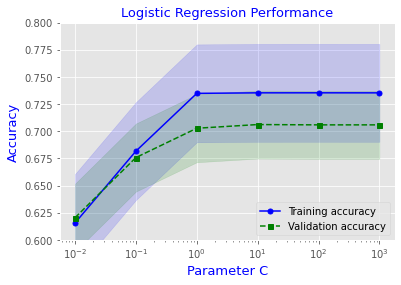

In [ ]:
validation_curve(param_range,np.array(training_scores),np.array(validation_scores))

In [ ]:
#Highest validation score is achieved for C=10.0
print(f'The highest validation score is {max(validation_scores)}')
index=np.argsort(validation_scores)[-1]
print(f'The highest validation score is achived for C={param_range[index]}')

The highest validation score is 0.7061812023708721
The highest validation score is achived for C=10.0


In [ ]:
lr_l1=LogisticRegression(C=10.0,
                         solver='saga',
                         class_weight='balanced',
                         penalty='l1',
                         random_state=seed)
lr_l1.fit(X_train_ohe,y_train)

LogisticRegression(C=10.0, class_weight='balanced', penalty='l1',
                   random_state=42, solver='saga')

In [ ]:
print('The test score is ',accuracy_score(y_test,lr_l1.predict(X_test_ohe)))

The test score is  0.7075924357888794


Since the average validation score for Logistic Regression with penalty='l2' is higher than for Logistic Regression with penalty='elasticnet' and penalty='l1' we will use the performance of Logistic Regression with penalty='l2' on our test set.

**Logistic Regression Test Score**

In [ ]:
probas=lr_l2.predict_proba(X_test_ohe)[:,1]
y_test_pred=lr_l2.predict(X_test_ohe)
auc=roc_auc_score(y_test,probas)
print('The test score is',accuracy_score(y_test,y_test_pred))
print()
print('The roc auc score (area) is:',auc)
print()
print('Classification report:')
print()
print(classification_report(y_test,y_test_pred))

The test score is 0.7095681625740897

The roc auc score (area) is: 0.7790295710947445

Classification report:

              precision    recall  f1-score   support

           0       0.62      0.74      0.67      1432
           1       0.79      0.69      0.74      2111

    accuracy                           0.71      3543
   macro avg       0.71      0.71      0.71      3543
weighted avg       0.72      0.71      0.71      3543



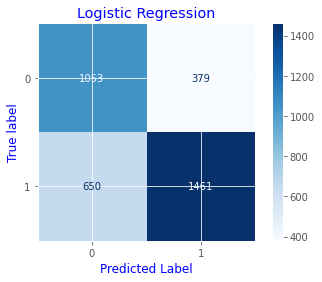

In [ ]:
#let's print the confusion matrix
plot_confusion_matrix(lr_l2,X_test_ohe,y_test,cmap='Blues')
plt.title('Logistic Regression',color='blue')
plt.xlabel('Predicted Label',color='blue')
plt.ylabel('True label',color='blue')
plt.savefig('lr_l2_confusion matrix',dpi=300,
            bbox_inches ="tight",
            pad_inches = 0.5,);

In [ ]:
def make_roc_curve(estimator,estimator_name,data):
  probas=estimator.predict_proba(data)[:,1]
  fpr,tpr,thresholds=roc_curve(y_test,
                               probas,
                               pos_label=1)
  roc_auc=auc(fpr,tpr)
  plt.plot(fpr,tpr,label=f'{estimator_name} (area={roc_auc:.2f})')
  plt.plot([0, 1],
           [0, 1],
           linestyle='--', 
           color=(0.6, 0.6, 0.6),
           label='Random guessing (area=0.5)')
  plt.plot([0, 0, 1],
           [0, 1, 1],
           linestyle=':',
           color='black',
           label='Perfect performance (area=1.0)')
  plt.xlabel('False positive rate',
             color='blue',
             fontsize=13)
  plt.ylabel('True positive rate',
             color='blue',
             fontsize=13)
  plt.xlim([-0.05,1.05])
  plt.ylim([-0.05,1.05])
  plt.legend(loc='best',fontsize=13)
  plt.title('The Roc plot',
            color='blue',
            fontsize=13)

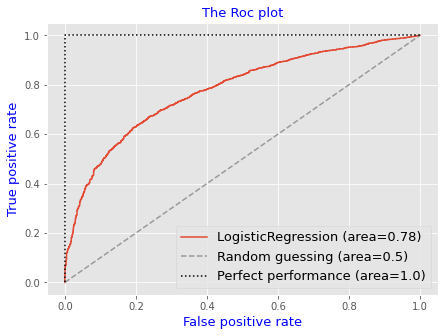

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(7,5))
make_roc_curve(lr_l2,'LogisticRegression',X_test_ohe)
plt.savefig('lr_l2_roc_plot',dpi=300,
            bbox_inches ="tight",
            pad_inches = 0.5,)

**Random Forest**
* We will use RandomForestClassifer to predict our target 'is_correct'.
* RandomForestClassifer is a bagging technique which helps with overfitting issues.
* We tuned hyperparameters using RandomSearchCV.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
seed=42
rf=RandomForestClassifier(random_state=seed,
                              class_weight={1:1,0:1.45})#majority/minority~1.45)
param_grid=[{'max_depth':[k for k in range(80,101,10)],
               'n_estimators':[200,300],
              'min_samples_split':[10,15,20,25,30],
              'min_samples_leaf':[20,25,30,35,40]}]
randomized_tree=RandomizedSearchCV(rf,
                  param_distributions=param_grid,
                  random_state=seed,
                  n_iter=5,
                  cv=2,
                  scoring='accuracy')
randomized_tree.fit(X_train_ohe,y_train)
import joblib
filename=filename = '/content/drive/MyDrive/Colab Notebooks/Online Educational Platforms\
/randomized_forest_tree_final_project.sav'
joblib.dump(randomized_tree,filename)

['/content/drive/MyDrive/Colab Notebooks/Online Educational Platforms/randomized_forest_tree_final_project.sav']

In [ ]:
print('The optimal parameters are:',randomized_tree.best_params_)
print()
print('The best 2-fold score is ',randomized_tree.best_score_)

The optimal parameters are: {'n_estimators': 200, 'min_samples_split': 30, 'min_samples_leaf': 25, 'max_depth': 80}

The best 2-fold score is  0.6689599209709286


**Random Forest Validation Score**

In [ ]:
#validation score
predictions_train=randomized_tree.predict(X_train_ohe)
predictions_valid=randomized_tree.predict(X_valid_ohe)
print('The training accuracy is ',accuracy_score(y_train,predictions_train))
print()
print('The validation accuracy is ',accuracy_score(y_valid,predictions_valid))

The training accuracy is  0.6812905729607677

The validation accuracy is  0.6851538244425628


**Random Forest Classifier Test score**

In [ ]:
predictions_test=randomized_tree.predict(X_test_ohe)
probas=randomized_tree.predict_proba(X_test_ohe)[:,1]
auc=roc_auc_score(y_test,probas)
print('The test score is ',accuracy_score(y_test,predictions_test))
print()
print('The roc auc score (area) is:',auc)
print()
print('The classification report is')

print(classification_report(y_test,predictions_test))

The test score is  0.663279706463449

The roc auc score (area) is: 0.7132767903691491

The classification report is
              precision    recall  f1-score   support

           0       0.61      0.46      0.52      1432
           1       0.69      0.80      0.74      2111

    accuracy                           0.66      3543
   macro avg       0.65      0.63      0.63      3543
weighted avg       0.66      0.66      0.65      3543



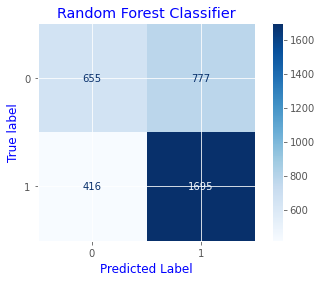

In [ ]:
#let's print the confusion matrix
plot_confusion_matrix(randomized_tree,X_test_ohe,y_test,cmap='Blues')
plt.title('Random Forest Classifier',color='blue')
plt.xlabel('Predicted Label',color='blue')
plt.ylabel('True label',color='blue')
plt.savefig('rf_confusion_matrix',dpi=300,
            bbox_inches ="tight",
            pad_inches = 0.5,);
  

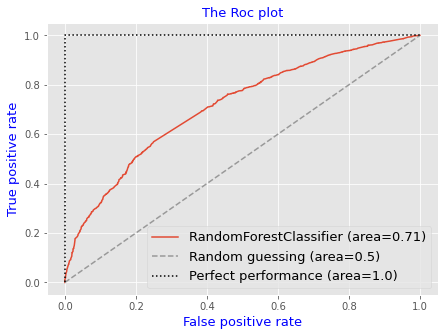

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(7,5))
make_roc_curve(randomized_tree,'RandomForestClassifier',X_test_ohe)
plt.savefig('rf_roc_plot',dpi=300,
            bbox_inches ="tight",
            pad_inches = 0.5,)

In [ ]:
from sklearn import tree

[Text(0.9759036144578314, 0.9938271604938271, 'X[255] <= 0.5\ngini = 0.5\nsamples = 35861\nvalue = [32765.65, 34091.0]'),
 Text(0.963855421686747, 0.9814814814814815, 'X[284] <= 0.5\ngini = 0.5\nsamples = 35669\nvalue = [32717.8, 33815.0]'),
 Text(0.9518072289156626, 0.9691358024691358, 'X[12] <= 0.5\ngini = 0.5\nsamples = 35452\nvalue = [32368.35, 33714.0]'),
 Text(0.9397590361445783, 0.9567901234567902, 'X[17] <= 0.5\ngini = 0.5\nsamples = 35201\nvalue = [32298.75, 33362.0]'),
 Text(0.927710843373494, 0.9444444444444444, 'X[271] <= 0.5\ngini = 0.5\nsamples = 35034\nvalue = [32040.65, 33283.0]'),
 Text(0.9156626506024096, 0.9320987654320988, 'X[231] <= 0.5\ngini = 0.5\nsamples = 34941\nvalue = [32023.25, 33154.0]'),
 Text(0.9036144578313253, 0.9197530864197531, 'X[1988] <= 0.5\ngini = 0.5\nsamples = 34677\nvalue = [31969.6, 32770.0]'),
 Text(0.891566265060241, 0.9074074074074074, 'X[221] <= 0.5\ngini = 0.5\nsamples = 34651\nvalue = [31920.3, 32760.0]'),
 Text(0.8795180722891566, 0.895

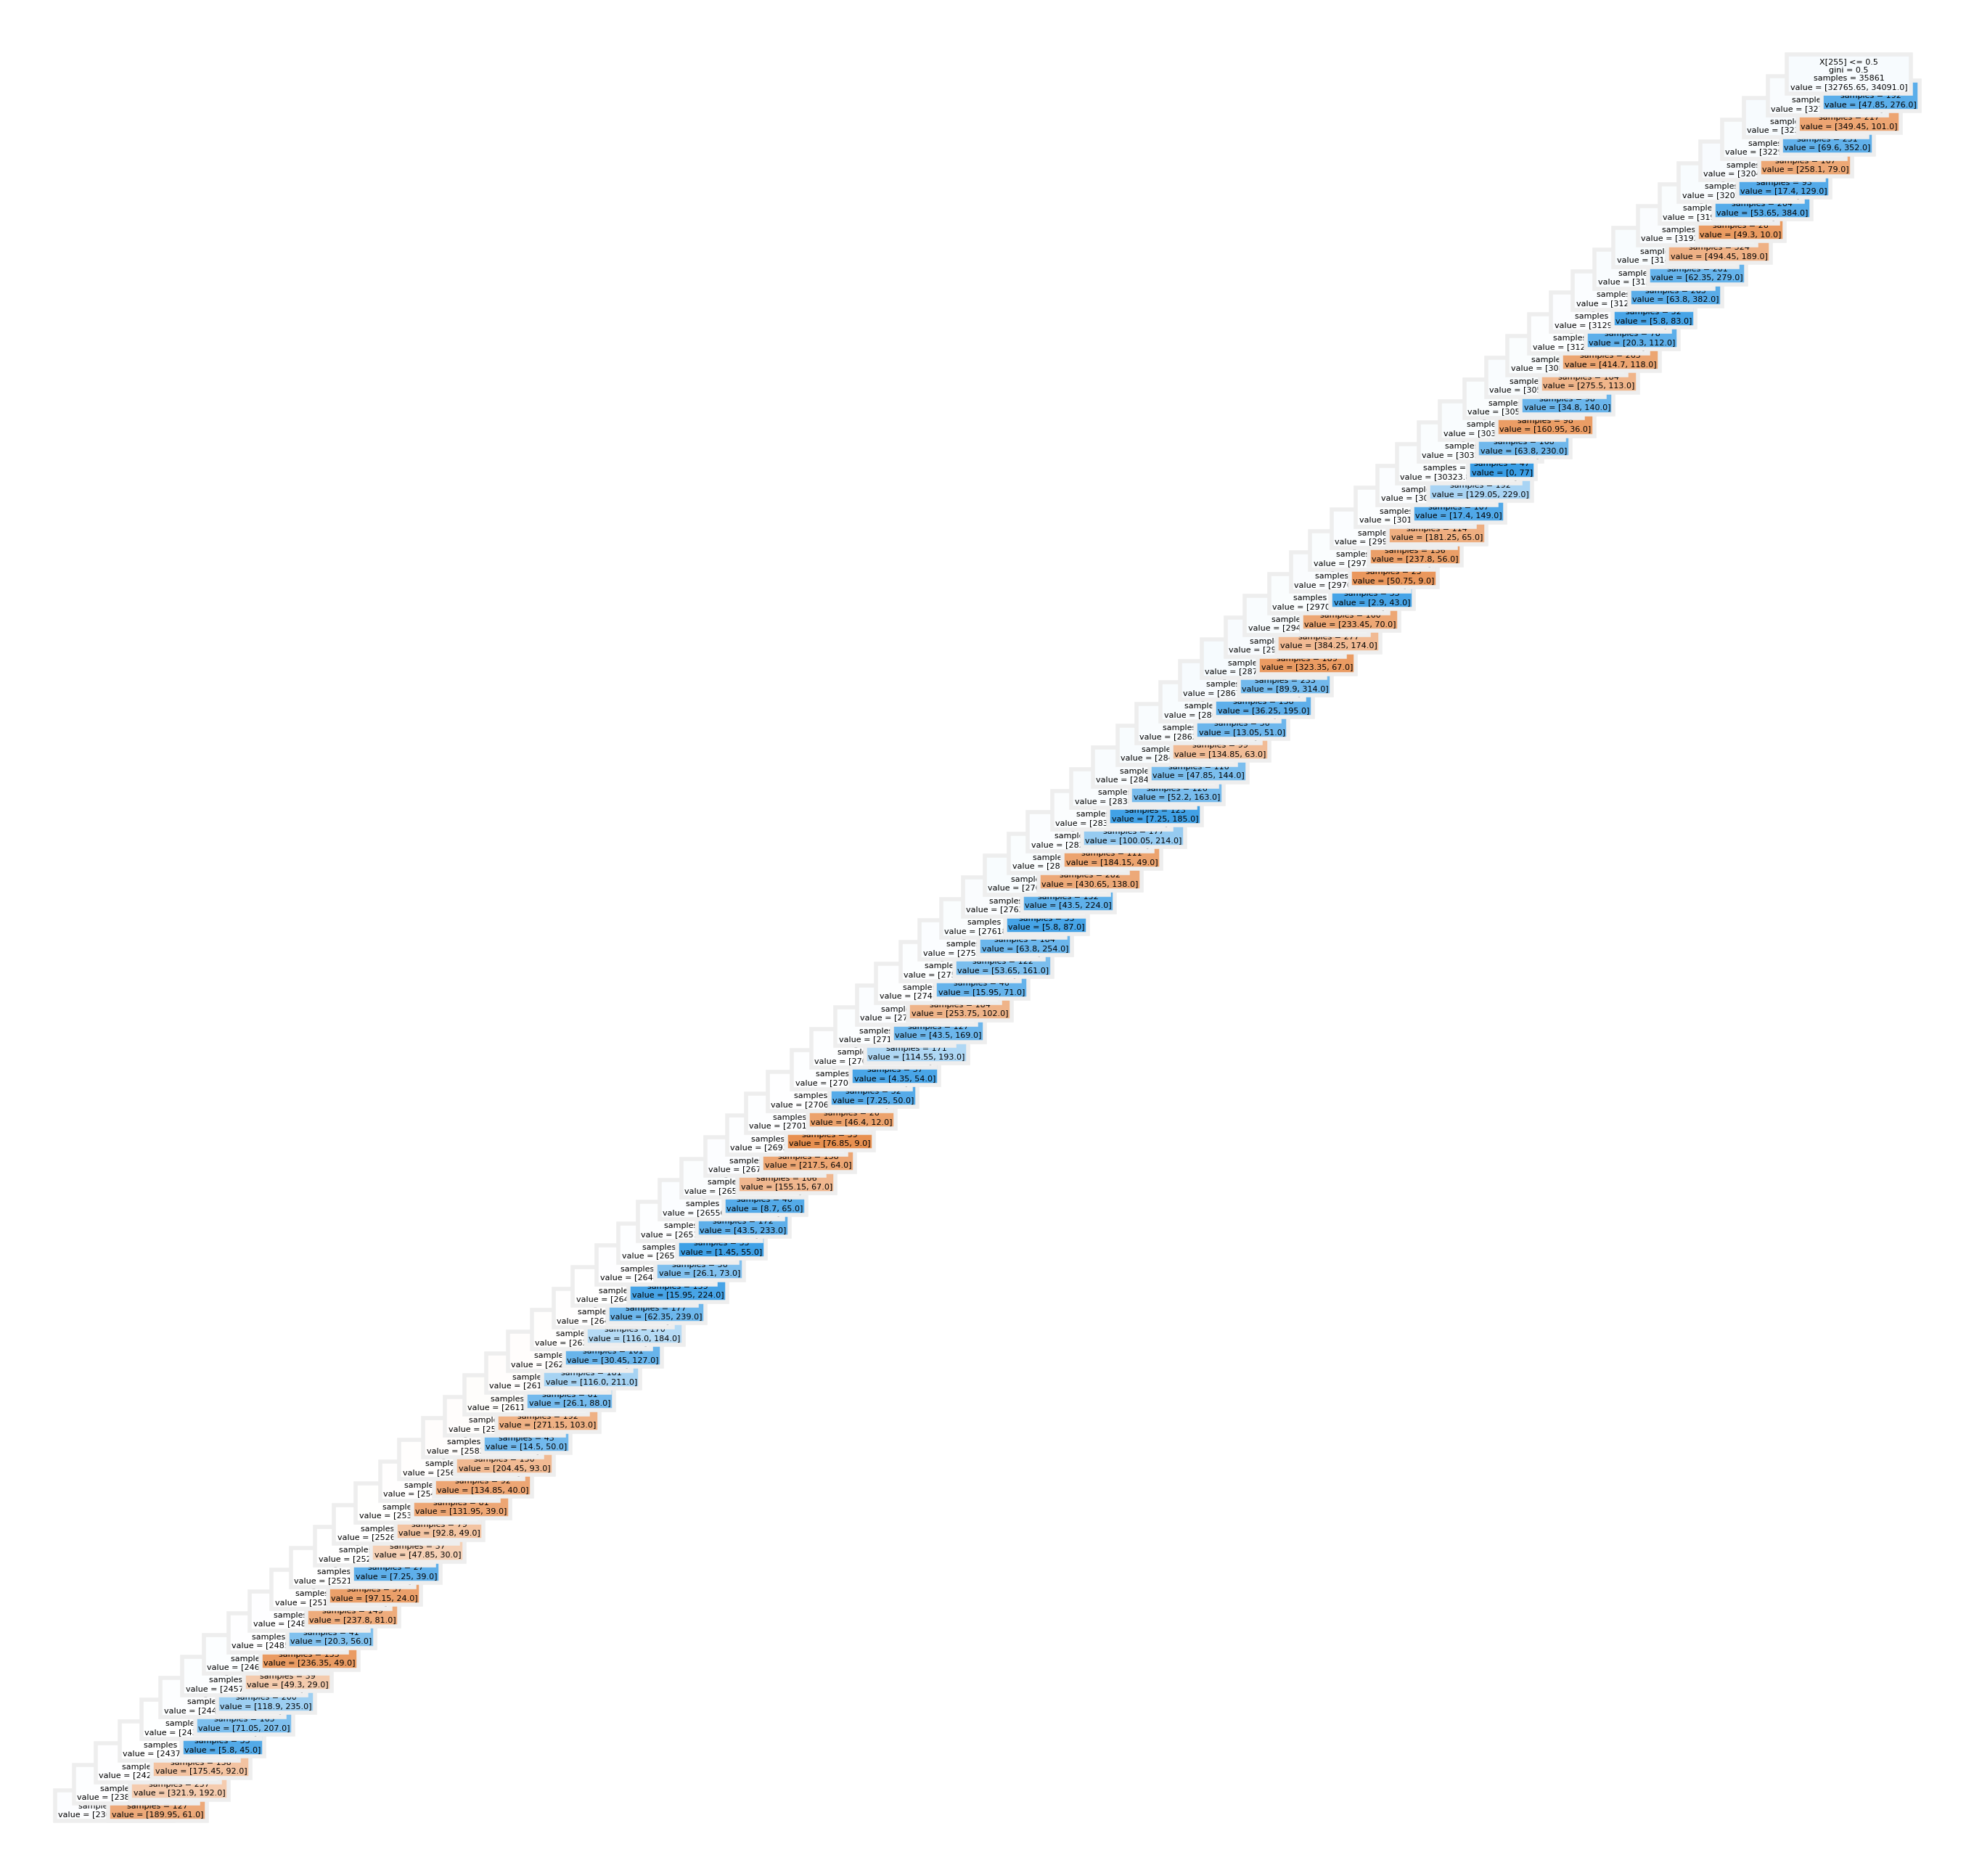

In [ ]:
clf=randomized_tree.best_estimator_
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(clf[0],filled=True)

**XGBoost**
* XBoost falls under the category of ensemble techniques (boosting approach).
* It usually decreases the bias of the model.


* Note we set `scale_pos_weight`=1.45 since the majority class/minority class is approximately 1.45. This parameter helps us deal with imbalanced data.
* We only tune n_estimators because it will take way more time to tune the other hyperparameters too.

In [ ]:
seed=42
n_estimators=[20,50]
xgb_train_scores=[]
xgb_valid_scores=[]
for i,n_estimator in enumerate(n_estimators):
  clf=XGBClassifier(objective='binary:logistic',
                     max_depth=50,
                     reg_lambda=1.0,
                     subsample=1,
                     random_state=seed,
                     n_estimators=n_estimator,
                     scale_pos_weight=1.45,
                     learning_rate=0.01)
  clf.fit(X_train_ohe,y_train)
  import joblib
  filename = f'/content/drive/MyDrive/Colab Notebooks/Online Educational Platforms/xgb_model_{i+1}_final_project.sav'
  joblib.dump(clf, filename)
  train_score=clf.score(X_train_ohe,y_train)
  valid_score=clf.score(X_valid_ohe,y_valid)
  xgb_train_scores.append(train_score)
  xgb_valid_scores.append(valid_score)

In [ ]:
print('Training scores:',xgb_train_scores)
print()
print('Validation scores:',xgb_valid_scores)

Training scores: [0.6533481512842224, 0.6475973751058425]

Validation scores: [0.6581992661586227, 0.6515664690939882]


In [ ]:
max_valid_score=max(xgb_valid_scores)
index=np.argmax(xgb_valid_scores)
print(f'The highest validation score is {max_valid_score}')
print(f'The highest validation score is achived for n_estimators={n_estimators[index]}')

The highest validation score is 0.6581992661586227
The highest validation score is achived for n_estimators=20


**XGBoost Test Score**

In [ ]:
import joblib
filename = '/content/drive/MyDrive/Colab Notebooks/Online Educational Platforms/xgb_model_1_final_project.sav'
xgb_model=joblib.load(filename)

In [ ]:
probas=xgb_model.predict_proba(X_test_ohe)[:,1]
y_test_pred=xgb_model.predict(X_test_ohe)
auc=roc_auc_score(y_test,probas)
print('The test score is',accuracy_score(y_test,y_test_pred))
print()
print('The roc auc score (area) is:',auc)
print()
print('Classification report:')
print()
print(classification_report(y_test,y_test_pred))


The test score is 0.6522720858029918

The roc auc score (area) is: 0.6387390537461395

Classification report:

              precision    recall  f1-score   support

           0       0.68      0.26      0.38      1432
           1       0.65      0.92      0.76      2111

    accuracy                           0.65      3543
   macro avg       0.66      0.59      0.57      3543
weighted avg       0.66      0.65      0.61      3543



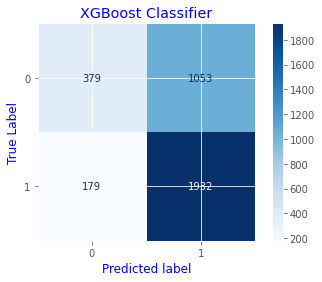

In [ ]:
#let's print the confusion matrix
plot_confusion_matrix(xgb_model,X_test_ohe,y_test,cmap='Blues')
plt.title('XGBoost Classifier',color='blue')
plt.xlabel('Predicted label',color='blue')
plt.ylabel('True Label',color='blue');
plt.savefig('xgb_confusion_matrix',dpi=300,
            bbox_inches ="tight",
            pad_inches = 0.5)

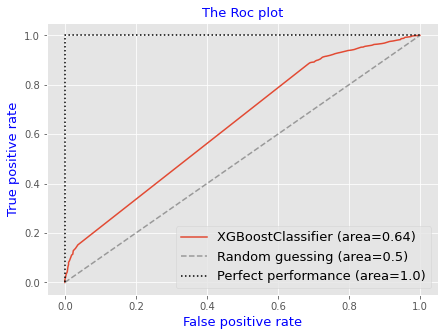

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(7,5))
make_roc_curve(xgb_model,'XGBoostClassifier',X_test_ohe)
plt.savefig('xgb_roc_plot',dpi=300,
            bbox_inches ="tight",
            pad_inches = 0.5);

**Summary.** 
* XGBoostClassifer does worst than
RandomForestClassifer and Logistic Regression.
* Logistic Regression performs better than the other ones with accuarcy=70.95 and roc auc score=77.90. 
* The performances of Logistic Regression, Random Foresrt,and XGBoost is summarized in the table below.

In [ ]:
performance={'model':['Logistic Regression',
                 'Random Forest Classifier',
                 'XGBoost'],
             'accuaracy':[70.95,66.32,65.22],
             'area':[0.78,0.71,0.63]}

summary=pd.DataFrame(performance)
summary

,model,accuaracy,area
0,Logistic Regression,70.95,0.78
1,Random Forest Classifier,66.32,0.71
2,XGBoost,65.22,0.63


Let's plot the auc score for each model along with roc curves. For this reason we created the function `summary_roc_curve` to help us plot roc curves.

In [ ]:
def summary_roc_curve(estimators,estimator_names,data):
  for i,estimator in enumerate(estimators):
    probas=estimator.predict_proba(data)[:,1]
    fpr,tpr,thresholds=roc_curve(y_test,
                               probas,
                               pos_label=1)
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,label=f'{estimator_names[i]} (area={roc_auc:.2f})')
  plt.plot([0, 1],
           [0, 1],
           linestyle='--', 
           color=(0.6, 0.6, 0.6),
           label='Random guessing (area=0.5)')
  plt.plot([0, 0, 1],
           [0, 1, 1],
           linestyle=':',
           color='black',
           label='Perfect performance (area=1.0)')
  plt.xlabel('False positive rate',
             color='blue',
             fontsize=13)
  plt.ylabel('True positive rate',
             color='blue',
             fontsize=13)
  plt.xlim([-0.05,1.05])
  plt.ylim([-0.05,1.05])
  plt.legend(loc='best',fontsize=13)
  plt.title('The Roc plot',
            color='blue',
            fontsize=13)

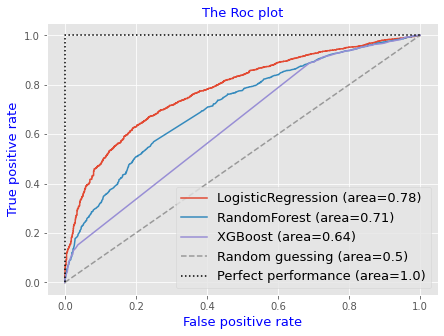

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(7,5))
summary_roc_curve([lr_l2,randomized_tree,xgb_model],
                  ['LogisticRegression','RandomForest','XGBoost'],X_test_ohe)
plt.savefig('summary_plot',dpi=300,
            bbox_inches ="tight",
            pad_inches = 0.5,);

## Explanation of the performance difference

It is impressive that Logistic Regression outperforms more powerful models such as Random Forest and XGBoost.

Let's take a closer look at Logistic Regression and Random Forest, for example, to explain the difference in their performances. 

In Logistic Regression, the weights 
$w_{1},w_{2},\ldots,w_{P}$ are computed via a gradient descent. Then if $w_{1}x_{1}+\cdots+w_{p}x_{p}\geq 0.0$, it outputs class label=1 or class label=0 otherwise. We have to note that the features $x_{1},\dots,x_{p}$ are user ids and question ids and they both  particiapte in the computation of the weights $w_{1},\dots,w_{p}$.

On the other hand, Random Forest creates a node and eventually leafes by optimizing some objective function such as entropy for example. However, if the max_depth is relatively small then Random Forest might look only at student ids for example to create a node and question ids might not play any role in the prediction of the target. As a result, Random Forest might perform poorly.

## Application of the Logistic Regression result.


The result of the logistic regression allows us to develop a ranking system based on the student performance.

The weights computed in logistic regression can be used to rank the students and the questions. In fact, the weights associated with user ids, rank the students. Bigger weights corespong to smarter students. The weights associated with question ids rank the difficulty of questions. Bigger weights correspond to easier questions.

This discussion is implemented in python below.

In [ ]:
#number of students and questions
unique_user_ids=len(set(train_data['user_id']))
unique_question_ids=len(set(train_data['question_id']))
print('The number of students is ',unique_user_ids)
print()
print('The number of questions is ',unique_question_ids)

The number of students is  542

The number of questions is  1774


In [ ]:
lr_l2.coef_.shape[1]==542+1774

True

In [ ]:
weights=lr_l2.coef_
student_weights=weights[0,:unique_user_ids]#weights associated with students
question_weights=weights[0,unique_user_ids:]#weights associated with questions
student_ranks=np.argsort(student_weights)# from lowest to top student
question_ranks=np.argsort(question_weights)#from easy to difficult question
top_students=pd.DataFrame({'weights':student_weights[student_ranks][::-1],
                           'student_ids':student_ranks[::-1],
                       'student_ranking':[k for k in range(1,unique_user_ids+1)]})#ranks students from top to 
                                                            #bottom

top_questions=pd.DataFrame({'weights':question_weights[question_ranks][::-1],
                           'question_ids':question_ranks[::-1],
                       'question_ranking':[k for k in range(1,unique_question_ids+1)]})#ranks questions from top to 
                                                            #bottom

In [ ]:
print('Ranking of students')
print(top_students)
print()
print('Ranking of questions')
print(top_questions)

Ranking of students
      weights  student_ids  student_ranking
0    2.928174          138                1
1    2.803151          531                2
2    2.700446          333                3
3    2.650999          240                4
4    2.558509          430                5
..        ...          ...              ...
537 -2.002044          478              538
538 -2.046823          426              539
539 -2.069409          347              540
540 -2.173404          502              541
541 -2.305575          534              542

[542 rows x 3 columns]

Ranking of questions
       weights  question_ids  question_ranking
0     2.198624          1165                 1
1     2.175962           487                 2
2     2.098998          1444                 3
3     2.062633            67                 4
4     2.020890           349                 5
...        ...           ...               ...
1769 -1.827746          1475              1770
1770 -1.877688          1387  

#Ensemble Techniques
**Goal.** Combine the previous classifiers via:
 * Majority Voting
 * Stacking Classiifer

**Note.** XGBoost and RandomForest Classifer are the examples of ensemble algorithms.

**VotingClassifier**

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing models in order to balance out their individual weaknesses.

In majority voting, the predicted class label for a particular sample is the class label that represents the majority (mode) of the class labels predicted by each individual classifier.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seed=42
clf1=LogisticRegression(C=1.0,
                         solver='sag',
                         class_weight='balanced',
                         random_state=seed)
clf2=RandomForestClassifier(random_state=seed,
                            class_weight={1:1,0:1.45},
                            n_estimators=200,
                            min_samples_split=30,
                            min_samples_leaf=25,
                            max_depth=80)
clf3=XGBClassifier(objective='binary:logistic',
                     max_depth=50,
                     reg_lambda=1.0,
                     subsample=1,
                     random_state=seed,
                     n_estimators=20,
                     scale_pos_weight=1.45,
                     learning_rate=0.01)
eclf=VotingClassifier(estimators=[('lr',clf1),('rf',clf2),('xgb',clf3)],
                      voting='soft',
                      weights=[4,1,1])
eclf.fit(X_train_ohe,y_train)
import joblib
filename = '/content/drive/MyDrive/Colab Notebooks/Online Educational Platforms/eclf_model_final_project.sav'
joblib.dump(eclf, filename)


['/content/drive/MyDrive/Colab Notebooks/Online Educational Platforms/eclf_model_final_project.sav']

**VotingClassifier Validation Score**

In [ ]:
#validation score
predictions_train=eclf.predict(X_train_ohe)
predictions_valid=eclf.predict(X_valid_ohe)
print('The training accuracy is ',accuracy_score(y_train,predictions_train))
print()
print('The validation accuracy is ',accuracy_score(y_valid,predictions_valid))

The training accuracy is  0.7357465424781259

The validation accuracy is  0.7085802991814846


**VotingClasifier Test Score**

In [ ]:
probas=eclf.predict_proba(X_test_ohe)[:,1]
y_test_pred=eclf.predict(X_test_ohe)
auc=roc_auc_score(y_test,probas)
print('The test score is',accuracy_score(y_test,y_test_pred))
print()
print('The roc auc score (area) is:',auc)
print()
print('Classification report:')
print()
print(classification_report(y_test,y_test_pred))

The test score is 0.7084391758396839

The roc auc score (area) is: 0.7781648534280399

Classification report:

              precision    recall  f1-score   support

           0       0.62      0.72      0.67      1432
           1       0.79      0.70      0.74      2111

    accuracy                           0.71      3543
   macro avg       0.70      0.71      0.70      3543
weighted avg       0.72      0.71      0.71      3543



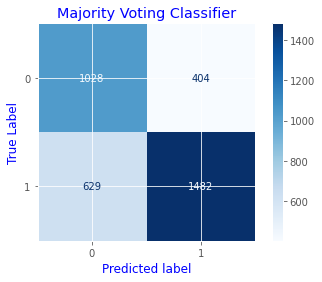

In [ ]:
#let's print the confusion matrix
plot_confusion_matrix(eclf,X_test_ohe,y_test,cmap='Blues')
plt.title('Majority Voting Classifier',color='blue')
plt.xlabel('Predicted label',color='blue')
plt.ylabel('True Label',color='blue');


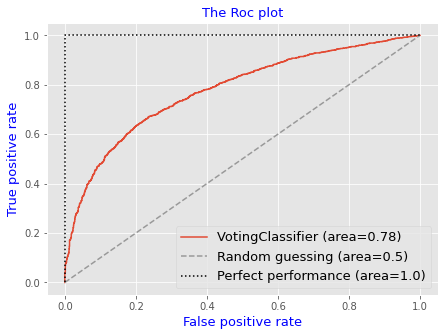

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(7,5))
make_roc_curve(eclf,'VotingClassifier',X_test_ohe)

**Conclusion**. 

VotingClassifier performs as well as the Logistic Regression.

**StackingClasssifier**

Stacking is ensemble method for combining estimators to reduce their biases. More precisely, the predictions of each individual estimator are stacked together and used as input to a final estimator to compute the prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
#individual estimators
seed=42
clf1=RandomForestClassifier(random_state=seed,
                            class_weight={1:1,0:1.45},
                            n_estimators=20,
                            min_samples_split=30,
                            min_samples_leaf=25,
                            max_depth=80)
clf2=XGBClassifier(objective='binary:logistic',
                     max_depth=80,
                     reg_lambda=1.0,
                     subsample=1,
                     random_state=seed,
                     n_estimators=20,
                     scale_pos_weight=1.45,
                     learning_rate=0.01)
estimators=[('rf',clf1),('xgb',clf2)]

In [ ]:
#final estimator
seed=42
final_estimator=LogisticRegression(C=1.0,
                         solver='sag',
                         class_weight='balanced',
                         random_state=seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
stack_clf=StackingClassifier(estimators=estimators,
                             final_estimator=final_estimator,
                             passthrough=True)
stack_clf.fit(X_train_ohe,y_train)
import joblib
filename = '/content/drive/MyDrive/Colab Notebooks/Online Educational Platforms/stack_model_final_project.sav'
joblib.dump(stack_clf, filename)

['/content/drive/MyDrive/Colab Notebooks/Online Educational Platforms/stack_model_final_project.sav']

**StackingClassifier Validation Score**

In [ ]:
#validation score
predictions_train=stack_clf.predict(X_train_ohe)
predictions_valid=stack_clf.predict(X_valid_ohe)
print('The training accuracy is ',accuracy_score(y_train,predictions_train))
print()
print('The validation accuracy is ',accuracy_score(y_valid,predictions_valid))

The training accuracy is  0.7342471069714931

The validation accuracy is  0.7071690657634773


**StackClassiifer Test Score**

In [ ]:
probas=stack_clf.predict_proba(X_test_ohe)[:,1]
y_test_pred=stack_clf.predict(X_test_ohe)
auc=roc_auc_score(y_test,probas)
print('The test score is',accuracy_score(y_test,y_test_pred))
print()
print('The roc auc score (area) is:',auc)
print()
print('Classification report:')
print()
print(classification_report(y_test,y_test_pred))

The test score is 0.7098504092576913

The roc auc score (area) is: 0.7790523964654417

Classification report:

              precision    recall  f1-score   support

           0       0.62      0.73      0.67      1432
           1       0.79      0.69      0.74      2111

    accuracy                           0.71      3543
   macro avg       0.71      0.71      0.71      3543
weighted avg       0.72      0.71      0.71      3543



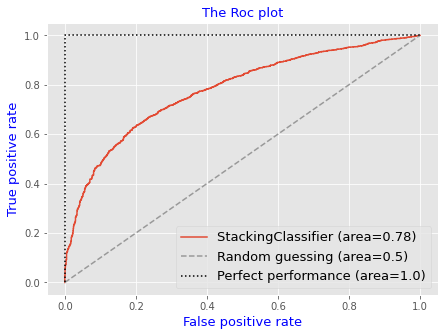

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(7,5))
make_roc_curve(stack_clf,'StackingClassifier',X_test_ohe)

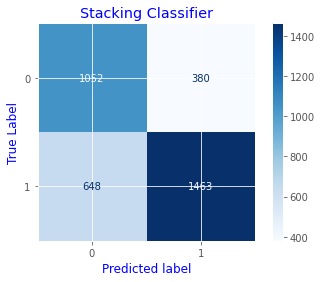

In [ ]:
#let's print the confusion matrix
plot_confusion_matrix(stack_clf,X_test_ohe,y_test,cmap='Blues')
plt.title('Stacking Classifier',color='blue')
plt.xlabel('Predicted label',color='blue')
plt.ylabel('True Label',color='blue');
plt.show()

**Conclusion**

* Majority Voting Classifier and StackingClassifer have the same accuracy score and auc score (area under ROC curve)
* StackingClassifier has higher recall (0.73) on the minority class (lass=0) than Majority Voting Classifier (0.72)

#Sparse format of the data
 * The students' info such as `user_id` and `question_id` can be represented via rows and columns respectively in a sparse matrix. 
 * The entries of the sparse matrix will be 0, 1 or Nan depending on whether the student asked the question correctly (entry=1) or not (entry =0) or the sudent has not attempted to answer the question yet (entry=Nan).
 * The parse matrix has been stored in the variable `matrix`.
 * The visual representation of the sparse matrix is given below.

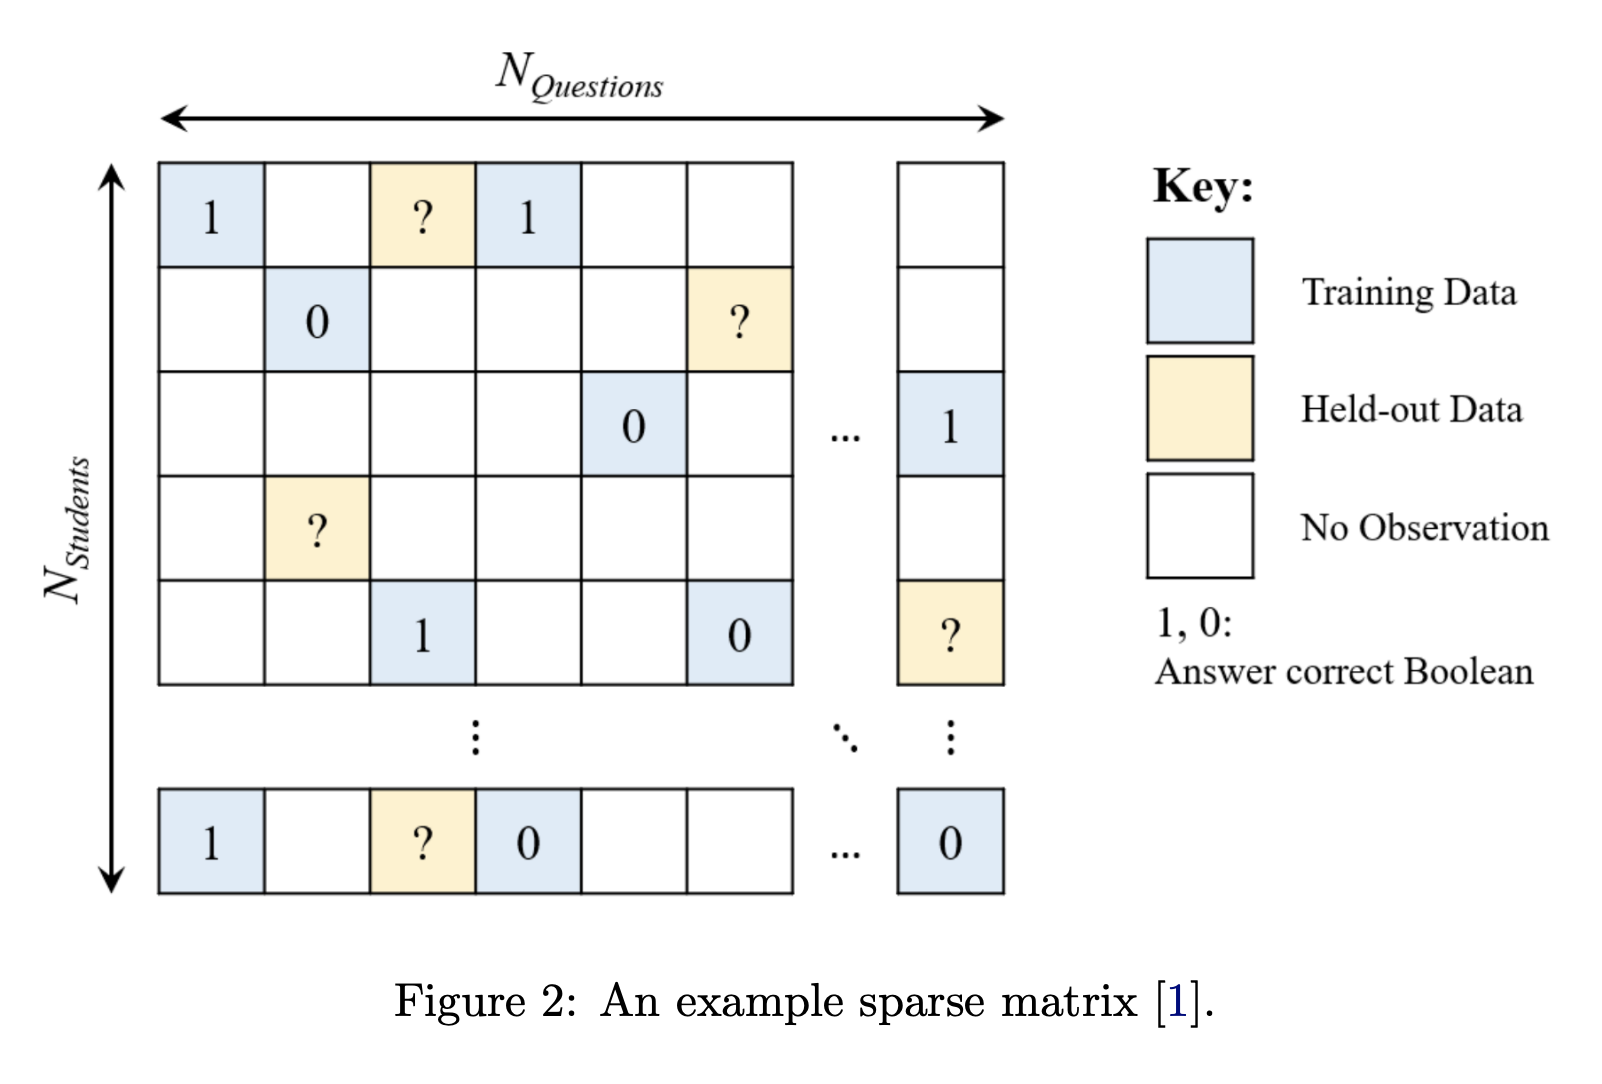

In [15]:
#Dimensions of the sparse matrix
matrix = load_train_sparse("starter_code/data")
rows,cols=matrix.toarray().shape
print(f'The number of rows of the sparse mtrix is {rows}')
print(f'The number of the columns of the sparse matrix is {cols}')

The number of rows of the sparse mtrix is 542
The number of the columns of the sparse matrix is 1774


In [16]:
#We can view all the entries ff the sparse matrix 
matrix.toarray()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan,  0., nan, ..., nan, nan, nan],
       [nan, nan,  1., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

#Imputaion of the sparse matrix

**Goal of using a sparse matrix**
* First, we want to impute the missing values in the sparse matrix.
* To impute the missing values, we will use `IterativeImputer` class.
* Then based on this imputation of missing values we will measure the potential performance of students on unseen questions via the function called `sparse_matrix_evaluate`.

To get the validation score and the test score we will use the function `sparse_matrix_evaluate`

In [17]:
def sparse_matrix_evaluate(data, matrix, threshold=0.5):
    """ Given the sparse matrix represent, return the accuracy of the prediction on data.

    :param data: A dictionary {user_id: list, question_id: list, is_correct: list}
    :param matrix: 2D matrix
    :param threshold: float
    :return: float
    """
    total_prediction = 0
    total_accurate = 0
    for i in range(len(data["is_correct"])):
        cur_user_id = data["user_id"][i]
        cur_question_id = data["question_id"][i]
        if matrix[cur_user_id, cur_question_id] >= threshold and data["is_correct"][i]:
            total_accurate += 1
        if matrix[cur_user_id, cur_question_id] < threshold and not data["is_correct"][i]:
            total_accurate += 1
        total_prediction += 1
    return total_accurate / float(total_prediction)

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

**XGBoost Imputation**

In [ ]:
seed=42
xgb_impute=XGBClassifier(max_depth=5,
                         n_estimators=20,
                         reg_alpha=0.1,
                         random_state=seed)
imputer=IterativeImputer(estimator=xgb_impute,
                         max_iter=5,
                         n_nearest_features=100,
                         random_state=seed)
matrix_imputed=imputer.fit_transform(matrix.toarray())

**XGBoost Imputation Validation Score**

In [ ]:
score_train=sparse_matrix_evaluate(train_data,matrix_imputed)
score_valid=sparse_matrix_evaluate(valid_data,matrix_imputed)
print('The training score is:',score_train)
print('The validation score is:',score_valid)

The training score is: 1.0
The validation score is: 0.6641264465142535


**XGBoost Imputation Test Score**

To compute recall, precision and auc score we will need an auxiliary function `predicted_labels`.

In [19]:
def predicted_labels(data,matrix,threshold=0.5):
  labels=[]
  for i in range(len(data["is_correct"])):
        cur_user_id = data["user_id"][i]
        cur_question_id = data["question_id"][i]
        if matrix[cur_user_id, cur_question_id] >= threshold:
          labels.append(1)
        else:
          labels.append(0)
  return labels

In [ ]:
predictions=predicted_labels(test_data,matrix_imputed)
score_test=sparse_matrix_evaluate(test_data,matrix_imputed)
print('The test score is',score_test)
print()
print('The classification report is')
print(classification_report(test_data['is_correct'],predictions))

The test score is 0.6502963590177815

The classification report is
              precision    recall  f1-score   support

           0       0.57      0.52      0.55      1432
           1       0.69      0.74      0.71      2111

    accuracy                           0.65      3543
   macro avg       0.63      0.63      0.63      3543
weighted avg       0.65      0.65      0.65      3543



**RandomForest Imputation**

In [ ]:
seed=42
rf_impute=RandomForestClassifier(max_depth=5,
                         n_estimators=20,
                         random_state=seed)
imputer=IterativeImputer(estimator=rf_impute,
                         max_iter=5,
                         n_nearest_features=100,
                         random_state=seed)
matrix_imputed=imputer.fit_transform(matrix.toarray())

**RandomForest Imputation Validation Score**

In [ ]:
score_train=sparse_matrix_evaluate(train_data,matrix_imputed)
score_valid=sparse_matrix_evaluate(valid_data,matrix_imputed)
print('The training score is:',score_train)
print('The validation score is:',score_valid)

The training score is: 1.0
The validation score is: 0.6776742873271239


**Random Forest Imputation Test Score**

In [ ]:
predictions=predicted_labels(test_data,matrix_imputed)
score_test=sparse_matrix_evaluate(test_data,matrix_imputed)
print('The test score is',score_test)
print()
print('The classification report is')
print(classification_report(test_data['is_correct'],predictions))

The test score is 0.68077900084674

The classification report is
              precision    recall  f1-score   support

           0       0.61      0.57      0.59      1432
           1       0.72      0.75      0.74      2111

    accuracy                           0.68      3543
   macro avg       0.67      0.66      0.67      3543
weighted avg       0.68      0.68      0.68      3543



**Ridge Imputation**

In [20]:
from sklearn.linear_model import Ridge
seed=42
lr_impute=Ridge(alpha=20.0,
                solver='saga',
                random_state=seed)
imputer=IterativeImputer(estimator=lr_impute,
                         max_iter=5,
                         n_nearest_features=100,
                         random_state=seed)
matrix_imputed_ridge=imputer.fit_transform(matrix.toarray())

**Ridge Imputation  Validation Score**

In [21]:
score_train=sparse_matrix_evaluate(train_data,matrix_imputed_ridge,threshold=0.5)
score_valid=sparse_matrix_evaluate(valid_data,matrix_imputed_ridge,threshold=0.5)
print('The training score is:',score_train)
print('The validation score is:',score_valid)

The training score is: 1.0
The validation score is: 0.6947502116850127


**Ridge Imputation Test Score**

In [22]:
predictions=predicted_labels(test_data,matrix_imputed_ridge,threshold=0.5)
score_test=sparse_matrix_evaluate(test_data,matrix_imputed_ridge,threshold=0.5)
print('The test score is',score_test)
print()
print('The classification report is')
print(classification_report(test_data['is_correct'],predictions))

The test score is 0.6954558283940163

The classification report is
              precision    recall  f1-score   support

           0       0.65      0.54      0.59      1432
           1       0.72      0.80      0.76      2111

    accuracy                           0.70      3543
   macro avg       0.68      0.67      0.67      3543
weighted avg       0.69      0.70      0.69      3543



**Conclusion.** The ridge imputation gives better result that XGBoost and RandomForest.

We can check that `matrix_imputed_ridge` does not have missing values.

In [23]:
sum(pd.DataFrame(matrix_imputed_ridge).isna().sum()>0)

0

# Ranking questions and students.
 After imputing the NaN values in the sparse matrix we can rank the questions and the students.

 To rank the questions we  
 *  Use `matrix_imputed_ridge` to cluster the students in groups using KMeans and then 
 * Rank the questions within each cluster

**KMeans**

 
 * Scale the data
 * Import KMeans

 * Choose the optimal number of clusters
 * Show the top 5 questions for each cluster

Scale the `matrix_imputed_ridge`

In [24]:
from sklearn.preprocessing import StandardScaler
scl=StandardScaler()
X_scaled=scl.fit_transform(matrix_imputed_ridge)

Import KMeans


In [25]:
from sklearn.cluster import KMeans

Determine the number of clusters.
* Elbow method
* Confirm elbow method via TSNE method
* Use `KElbowVisualizer` to determine the final( optimal) number of clusters

Elbow method 

In [56]:
seed=42
distortions=[]
num_clusters=11
for i in range(1,num_clusters):
  km=KMeans(n_clusters=i,
            init='k-means++',
            n_init=50,
            max_iter=300,
            random_state=seed)
  km.fit(X_scaled)
  distortions.append(km.inertia_)

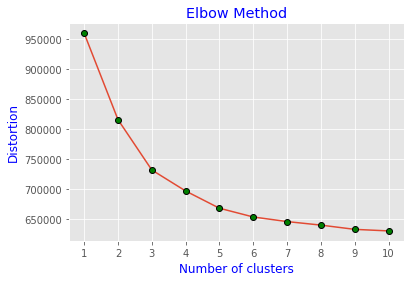

In [57]:
plt.style.use('ggplot')
plt.plot(range(1,num_clusters),
         distortions,marker='o',
         markeredgecolor='black',
         markerfacecolor='green')
plt.xlabel('Number of clusters',color='blue')
plt.ylabel('Distortion',color='blue')
plt.xticks(range(1,num_clusters))
plt.title('Elbow Method',color='blue');

The optimal number of clusters is between 3 and 4

TSNE visualizitaions

In [58]:
from sklearn.manifold import TSNE


In [59]:
seed=42
model=TSNE(learning_rate=800,
           random_state=seed)
transformed=model.fit_transform(X_scaled)

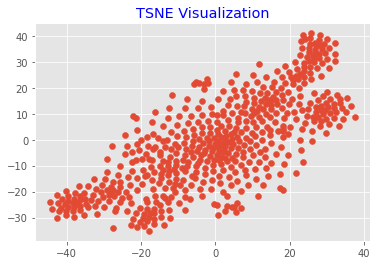

In [60]:
plt.style.use('ggplot')
xs=transformed[:,0]
ys=transformed[:,1]
plt.title('TSNE Visualization',color='blue')
plt.scatter(xs,ys,);

**Conclusion.** 

* Both approaches converge to the number of clusters of 3 or 4.

Now, use `KElbowVisualizer`

In [61]:
from yellowbrick.cluster import KElbowVisualizer

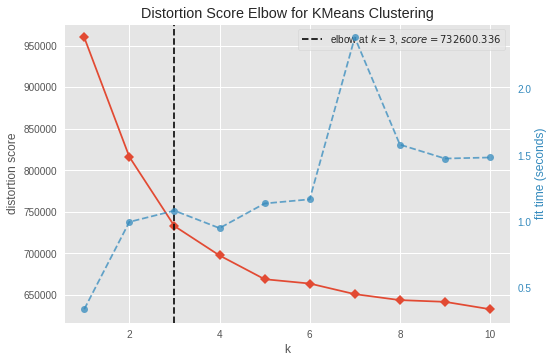

In [62]:
plt.style.use('ggplot')
seed=42
model = KMeans(random_state=seed)
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(X_scaled)
visualizer.show()

**Conclusion.** 

We will proceed with three clusters.

Show the top 5 questions (difficult-->easy) for each cluster.
To do that:
* We order the questions based on the cluster cenrters of each cluster.
* The lower the center cluster the more difficult the question is .

In [63]:
seed=42
num_clusters=3
km=KMeans(n_clusters=num_clusters,random_state=seed)
km.fit(X_scaled)

KMeans(n_clusters=3, random_state=42)

In [64]:
df_clust=pd.DataFrame(X_scaled,columns=['ID_'+str(k) for k in range(0,X_scaled.shape[1])])
df_clust['labels']=km.labels_

In [65]:
num_clusters=3#number of clusters 
top=5 #number of top questions from difficult to easy ones
for i in range(num_clusters):
  sorted_indices=np.argsort(km.cluster_centers_[i])
  top_questions=df_clust.columns[sorted_indices][:top]
  string=f"The top {top} questions in cluster {i} are: "
  print(string,*top_questions)
  print()


The top 5 questions in cluster 0 are:  ID_125 ID_582 ID_1019 ID_708 ID_1176

The top 5 questions in cluster 1 are:  ID_509 ID_1224 ID_1236 ID_1606 ID_777

The top 5 questions in cluster 2 are:  ID_1298 ID_186 ID_1102 ID_1208 ID_928



**Note.** 

* We first imputed the sparse matrix. Then we managed to rank the questions based on every student's predicted answer for each question.
* Via logistic regression, we ranked all the question based on the students' respond to not ncessarily each question using the model's (logistic regression) weights.


Visualize the clusters

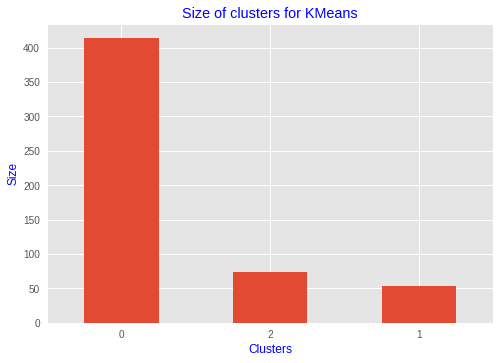

In [66]:
#visualize the size the clusters
df_clust['labels'].value_counts().plot(kind='bar',
                                       rot=0);
plt.xlabel('Clusters',color='blue')
plt.title('Size of clusters for KMeans',color='blue')
plt.ylabel('Size',color='blue');

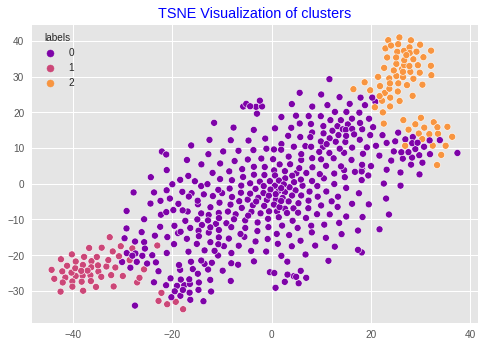

In [67]:
sns.scatterplot(x=xs,y=ys,hue=df_clust['labels'],
                palette=sns.color_palette('plasma',3),
                )
plt.title('TSNE Visualization of clusters',color='blue');

Hierarchical Clustering

In [38]:
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram

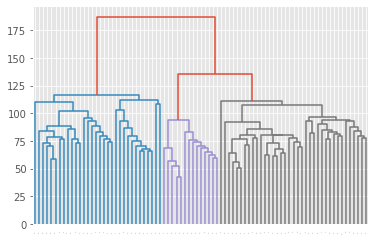

In [39]:
mergings=linkage(X_scaled,method='complete')
tree=dendrogram(mergings,
           p=10,#condense the tree
           truncate_mode='level',
           leaf_rotation=45,
           leaf_font_size=1)

The dendrogram shows that there are three clusters.

In [40]:
labels=fcluster(mergings,125,criterion='distance')
print('The unique labels are: ',*np.unique(labels))
print('The total number of clusters is ',len(np.unique(labels)))

The unique labels are:  1 2 3
The total number of clusters is  3


**Note.** The count of clusters in Scipy starts at one and not at zero as in scikitlearn. 

Put the scaled data and the corresponding labels together.

In [41]:
df_hier=pd.DataFrame(X_scaled,columns=['ID_'+str(k) for k in range(0,X_scaled.shape[1])])
df_hier['labels']=labels

Ranks the questions based on the average performance of the students for every question within each cluster.
In particular, print the top 5 questions (difficult-->easy)

In [42]:
performance=df_hier.groupby(by=['labels']).mean()#average performance of every cluster of 
#students for each question
performance

,ID_0,ID_1,ID_2,ID_3,ID_4,ID_5,ID_6,ID_7,ID_8,ID_9,...,ID_1764,ID_1765,ID_1766,ID_1767,ID_1768,ID_1769,ID_1770,ID_1771,ID_1772,ID_1773
labels,,,,,,,,,,,,,,,,,,,,,
1,-1.128557,-0.260256,-0.867376,-0.861146,-1.571441,-1.021347,-1.072840,-1.344434,-1.694082,-0.516868,...,-1.595537,-1.341279,0.076103,0.146709,-0.122668,-0.436197,-0.902944,-0.357059,-0.830421,-0.761780
2,1.553925,0.462178,0.764495,0.465484,2.402345,1.395760,1.681529,1.739318,2.125461,0.645938,...,1.924009,1.302736,0.052635,-0.282997,0.133018,0.580148,0.509543,0.396523,0.873743,0.712126
3,0.057293,0.007305,0.068486,0.084694,0.066201,0.052450,0.042840,0.074616,0.097787,0.029980,...,0.096526,0.099047,-0.012820,-0.002840,0.008269,0.023308,0.087583,0.023538,0.057500,0.057833


In [43]:
num_clusters=3#number of clusters 
top=5 #number of top questions from difficult to easy ones
for i in range(num_clusters):
  sorted_indices=np.argsort(performance.iloc[i,:])
  top_questions=performance.columns[sorted_indices][:top]
  string=f"The top {top} questions in cluster {i+1} are: "
  print(string,*top_questions)
  print()

The top 5 questions in cluster 1 are:  ID_509 ID_1606 ID_1224 ID_1236 ID_1170

The top 5 questions in cluster 2 are:  ID_1298 ID_1304 ID_1102 ID_186 ID_1179

The top 5 questions in cluster 3 are:  ID_1298 ID_1102 ID_816 ID_818 ID_1745



Visualize the clusters

In [45]:
from sklearn.manifold import TSNE
seed=42
model=TSNE(learning_rate=800,
           random_state=seed)
transformed=model.fit_transform(X_scaled)

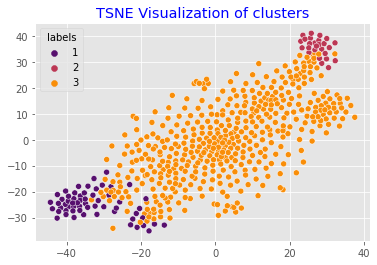

In [46]:
xs=transformed[:,0]
ys=transformed[:,1]
sns.scatterplot(x=xs,y=ys,hue=df_hier['labels'],
                palette=sns.color_palette('inferno',3)
                )
plt.title('TSNE Visualization of clusters',color='blue');

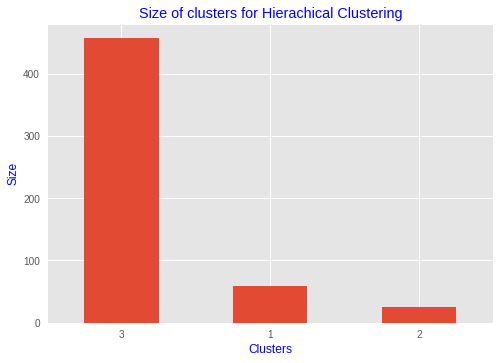

In [68]:
df_hier['labels'].value_counts().plot(kind='bar',
                                       rot=0);
plt.xlabel('Clusters',color='blue')
plt.title('Size of clusters for Hierachical Clustering',color='blue')
plt.ylabel('Size',color='blue');

In [47]:
df_hier.head()

,ID_0,ID_1,ID_2,ID_3,ID_4,ID_5,ID_6,ID_7,ID_8,ID_9,...,ID_1765,ID_1766,ID_1767,ID_1768,ID_1769,ID_1770,ID_1771,ID_1772,ID_1773,labels
0,-1.470800,0.098613,-0.266141,-0.097029,-0.832754,-0.393942,-0.509472,-0.480125,-1.269608,-0.402154,...,-0.441782,0.585859,0.178503,-0.030573,-0.405504,-0.237303,-0.220296,-0.222761,-0.166350,1
1,0.219023,-4.693674,-0.000669,-0.016837,0.142897,0.703702,0.031393,0.214262,0.066843,0.061576,...,-0.010529,-0.006461,-0.066273,-0.009170,-0.090005,-0.003312,0.008675,0.004787,0.050786,3
2,0.028153,0.067849,2.929800,0.116415,0.009476,0.099556,0.063179,0.118245,0.048681,0.092100,...,0.312926,0.031143,-2.299201,-0.004289,0.076034,2.178286,-0.088672,-0.165150,-0.200464,3
3,0.039182,0.084601,-4.127994,2.011004,0.021308,0.039951,0.091176,0.029985,0.048885,-0.050117,...,-0.205921,-0.072519,0.463472,0.034249,0.117630,-0.857184,0.079750,0.465808,-3.879607,3
4,-0.144845,-0.047883,-0.002357,-0.003731,-2.109964,-0.075190,-0.090314,0.026209,-0.189353,-0.044790,...,0.020201,-0.255719,-0.013150,-0.005818,-0.009748,-0.008672,0.030656,0.031870,-0.024566,3


Gaussian Mixture Model (GMM)
* One disadvantage of KMeans is that it works well then the clusters has spherical shapes.
* In case when the clusters do not have spherical shapes then GMM perform well.
* Also, GMM's are universal approximators of densitites.

In [26]:
from sklearn.mixture import GaussianMixture

We implement Gaussian Mixture for three clusters (n_components=3)

In [27]:
seed=42
gm=GaussianMixture(n_components=3,random_state=seed)
gm.fit(matrix_imputed_ridge)

GaussianMixture(n_components=3, random_state=42)

Predict labels for each data sample

In [48]:
df_mixture=pd.DataFrame(matrix_imputed_ridge,
                                columns=['ID_'+str(k) for k in range(0,matrix_imputed_ridge.shape[1])])
df_mixture['labels']=gm.predict(matrix_imputed_ridge)


Print the top 5 questions (difficult-->easy) for each cluster.

In [49]:
num_clusters=3#number of clusters 
top=5 #number of top questions from difficult to easy ones
for i in range(num_clusters):
  sorted_indices=np.argsort(gm.means_[i])#indices of sorted means of Guassin component
  top_questions=df_mixture.columns[sorted_indices][:top]
  string=f"The top {top} questions in cluster {i+1} are: "
  print(string,*top_questions)
  print()

The top 5 questions in cluster 1 are:  ID_1460 ID_817 ID_1383 ID_4 ID_1149

The top 5 questions in cluster 2 are:  ID_818 ID_1499 ID_1475 ID_1626 ID_1527

The top 5 questions in cluster 3 are:  ID_1410 ID_1626 ID_346 ID_900 ID_1527



Visualize clusters

In [50]:
from sklearn.manifold import TSNE
seed=42
model=TSNE(learning_rate=800,
           random_state=seed)
transformed=model.fit_transform(matrix_imputed_ridge)

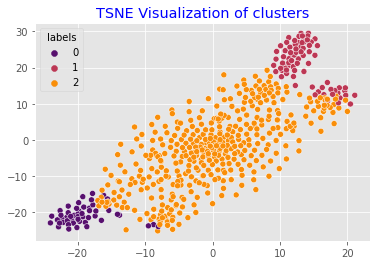

In [51]:
xs=transformed[:,0]
ys=transformed[:,1]
sns.scatterplot(x=xs,y=ys,hue=df_mixture['labels'],
                palette=sns.color_palette('inferno',3)
                )
plt.title('TSNE Visualization of clusters',color='blue');

Visualize the size of clusters

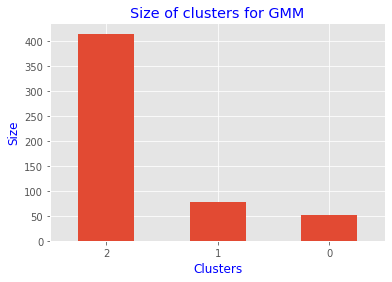

In [55]:
#visualize the size the clusters
df_mixture['labels'].value_counts().plot(kind='bar',
                                       rot=0);
plt.xlabel('Clusters',color='blue')
plt.title('Size of clusters for GMM',color='blue')
plt.ylabel('Size',color='blue');

In [53]:
df_mixture.groupby(by=['labels']).mean()

,ID_0,ID_1,ID_2,ID_3,ID_4,ID_5,ID_6,ID_7,ID_8,ID_9,...,ID_1764,ID_1765,ID_1766,ID_1767,ID_1768,ID_1769,ID_1770,ID_1771,ID_1772,ID_1773
labels,,,,,,,,,,,,,,,,,,,,,
0,0.302803,0.500460,0.497697,0.651476,0.053942,0.258426,0.508839,0.478703,0.148151,0.593553,...,0.259898,0.430566,0.562865,0.543322,0.925761,0.547464,0.594909,0.451333,0.722096,0.467349
1,0.634227,0.557483,0.674512,0.816224,0.534073,0.508913,0.783776,0.861873,0.740264,0.708210,...,0.730488,0.753797,0.560075,0.508328,0.935482,0.610579,0.787297,0.501383,0.814707,0.655956
2,0.490902,0.528998,0.578955,0.719860,0.324220,0.395848,0.672747,0.701605,0.509937,0.648557,...,0.549320,0.578411,0.550203,0.520532,0.930767,0.578343,0.693972,0.479931,0.772300,0.542536
